In [4]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

def load_pets_data(loading_method):
    if loading_method == 'kaggle':
        data_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder/train'
    elif loading_method == 'direct':
        data_path = 'pets/'
    classes = {'Sad': 0, 'happy': 1, 'Angry': 2,'Other': 3}
    imgs = []
    labels = []

    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.endswith('.jpg')]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                # Resize the image to match the input shape expected by the model
                image = image.resize((256, 256))
                # Convert the image to numpy array
                image_array = np.array(image)
                # Check if image has 3 channels (RGB), if not, convert it to RGB
                if image_array.ndim == 2:
                    image_array = np.stack((image_array,) * 3, axis=-1)
                imgs.append(image_array)
                labels.append(i)

    X = np.array(imgs)
    y = to_categorical(labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=True,stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, shuffle=True,stratify=y_train)

    
    return X_train, y_train, X_val, y_val, X_test, y_test, len(classes)


In [5]:
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_pets_data('kaggle')
input_shape = X_train.shape[1:]

100%|██████████| 250/250 [00:00<00:00, 342.98it/s]


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ResNet50-based model
def resnet50_based_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(190, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model


# Load data
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_pets_data('kaggle')
input_shape = X_train.shape[1:]

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

# Build model
model = resnet50_based_model(input_shape, num_classes)

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

# Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stopping, reduce_lr])

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


100%|██████████| 250/250 [00:00<00:00, 358.08it/s]


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,977,786 (91.47 MB)

 Trainable params: 390,074 (1.49 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/27 ━━━━━━━━━━━━━━━━━━━━ 9:47 23s/step - accuracy: 0.2188 - loss: 1.8069

I0000 00:00:1714038152.636498      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714038152.689416      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/27 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2894 - loss: 2.2851

W0000 00:00:1714038167.665243      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.3049 - loss: 2.1657

W0000 00:00:1714038174.082637      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.51579, saving model to best_model.keras


W0000 00:00:1714038182.868806      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.3055 - loss: 2.1561 - val_accuracy: 0.5158 - val_loss: 1.1802 - learning_rate: 0.0010
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.3995 - loss: 1.2436
Epoch 2: val_accuracy improved from 0.51579 to 0.52632, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 400ms/step - accuracy: 0.4002 - loss: 1.2439 - val_accuracy: 0.5263 - val_loss: 1.0973 - learning_rate: 0.0010
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.4936 - loss: 1.1682
Epoch 3: val_accuracy improved from 0.52632 to 0.53684, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 404ms/step - accuracy: 0.4938 - loss: 1.1674 - val_accuracy: 0.5368 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.5072 - loss: 1.1472
Epoch 4: val_accuracy improved from 0.53684 to 0.61053, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 402ms/step - accur

W0000 00:00:1714039029.668991      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [7]:
res = model.evaluate(X_test, y_test)

test_accuracy = res[-1]

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9229 - loss: 0.1875
test_accuracy = 90.0 %
Chance level: 25.0%


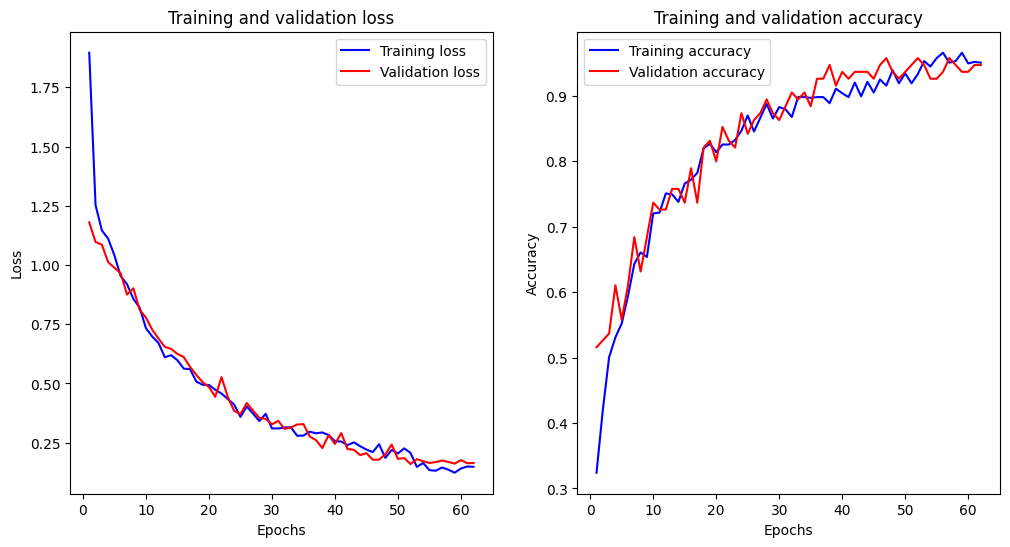

In [8]:
import matplotlib.pyplot as plt


# Extract loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Extract number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [9]:
# Check model architecture
#loaded_model.summary()

# Make predictions with sample data
sample_predictions = model.evaluate(X_test,y_test)

# Print sample predictions
print("Sample Predictions:")
print(sample_predictions)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9229 - loss: 0.1875
Sample Predictions:
[0.23566699028015137, 0.8999999761581421]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


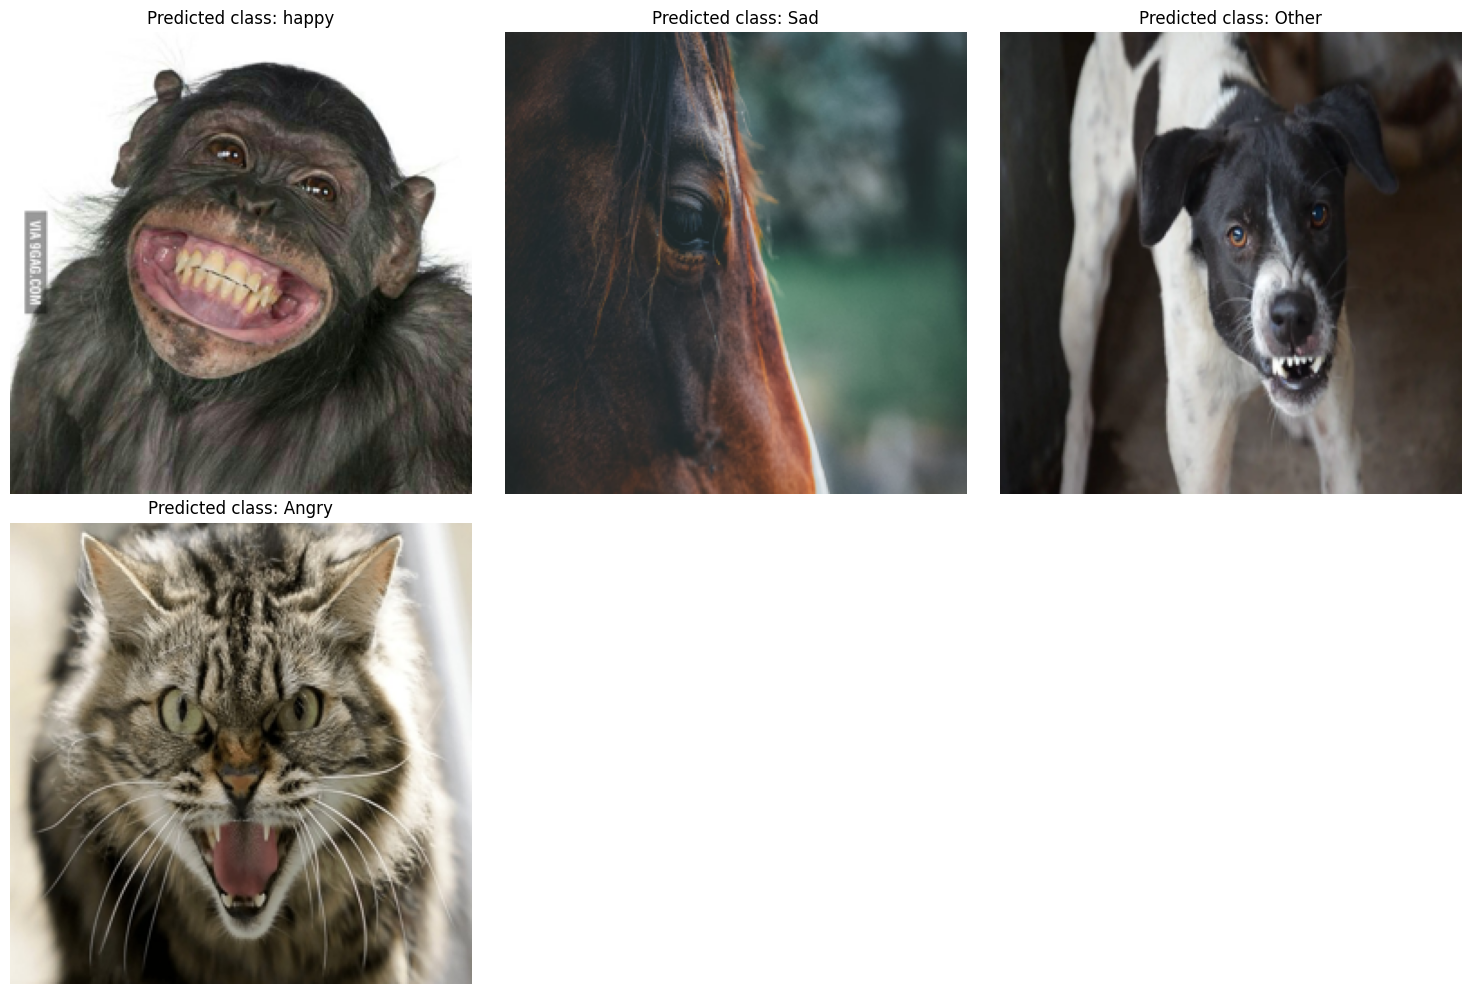

In [30]:
import os
import random
import numpy as np
import requests
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import io

# Define the data path and subfolders
data_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder/train'
subfolders = ['Sad', 'happy', 'Angry','Other']

# List of image URLs or file paths
image_urls = [
    "https://images-cdn.9gag.com/photo/ad6XVOD_700b.jpg",
    "https://equipepper.com/wp-content/uploads/2022/07/pexels-photo-1411709.jpeg",
    "https://www.purelypetsinsurance.co.uk/media/p0mm1krz/dog-angry-2.jpg?format=webp",
    "https://www.shutterstock.com/image-photo/angry-cat-closeup-growls-600nw-419227960.jpg",
  
]

num_images = len(image_urls)
num_rows = (num_images + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

for i, image_url in enumerate(image_urls):
    # Load image from URL
    response = requests.get(image_url)
    image_content = response.content

    # Convert image content to PIL Image object
    image = Image.open(io.BytesIO(image_content))

    # Resize the image to match the input shape expected by the model
    image = image.resize((256, 256))

    # Convert the image to numpy array
    image_array = np.array(image)

    # Make predictions
    predictions = model.predict(np.expand_dims(image_array, axis=0))[0]

    # Post-process predictions
    predicted_class_index = np.argmax(predictions)
    predicted_class = subfolders[predicted_class_index]

    # Display the image
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Predicted class: {predicted_class}")

# Hide empty subplots
for i in range(num_images, num_rows * 3):
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()
